In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from scipy.signal import find_peaks as pk
from scipy.optimize import curve_fit as cf
from math import floor

def leermd(filename):
    result = []
    df = read_csv(filename, sep='\t', skiprows=3, decimal=',')
    nparray = df.values
    nparray = nparray[~np.isnan(nparray).any(axis=1)]
    for cols in range(nparray.shape[1]):
        out = nparray[:,cols]
        result.append(out)
    return result

m_list = np.array([0.74482,0.69515,0.50025,0.54997,0.244567,0.1949,0.049667,0.099467,0.291367,0.596717,0.791617,0.6942])+0.16774
err_m = 0.0001
err_pos_st = 0.00535
err_t = 0.01
l_eq = 0.5475
l0 = 0.292
h = 1.38
g = 9.79688239

False


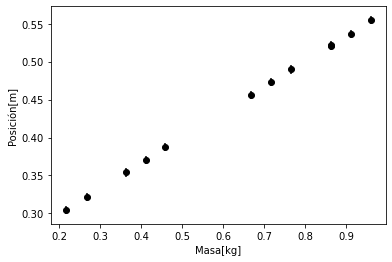

0.23250096755460095


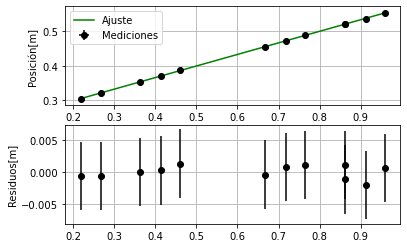

In [15]:
def static_pos(n):
    tsA,posA = leermd(str(n)+'A.txt')
    tsB,posB = leermd(str(n)+'B.txt')
    A = np.mean(h-l0-posA)
    B = np.mean(h-l0-posB)
    return (A+B)/2

pos_st = []
for i in range(len(m_list)):
    pos_st.append(static_pos(i+1))

def lineal(x,a,b): return(-a*x+b)

def ejes_lineal(ind,dep,err_ind,err_dep):
    x = np.array(ind)
    y = np.array(dep)
    err_x = err_ind
    err_y = err_dep
    err_y_array = np.ones_like(y)
    for i in range(len(y)):
        err_y_array[i] = err_y
    popt,cov = cf(lineal,x,y)
    A,B = popt
    cambio = False
    if err_dep*A > 0.1*err_ind:
        if err_dep*0.1 > err_ind/A:
            x = np.array(dep)
            y = np.array(ind)
            err_x = err_dep
            err_y = err_ind
            err_y_array = np.ones_like(y)
            for i in range(len(y)):
                err_y_array[i] = err_y
            popt,cov = cf(lineal,x,y)
            A,B = popt
            cambio = True
        else:
            err_x = err_ind
            err_y = err_dep**2+(err_ind*A)**2
            while err_x*A > 0.1*err_y:
                err_y = err_dep**2+(err_ind*A)**2
                print('minicambio')
    sort_idx = x.argsort()
    x = x[sort_idx]
    y = y[sort_idx]
    x_adj = np.linspace(min(m_list),max(m_list),100)
    y_adj = lineal(x_adj,A,B)
    err_A = cov[0,0]
    err_B = cov[1,1]
    return [[x,y],[err_x,err_y]],[x_adj,y_adj],[[A,B],[err_A,err_B]],cambio

points_st,adj_st,things_st,cambio_st = ejes_lineal(m_list,pos_st,err_m,err_pos_st)
print(cambio_st)
A_st = things_st[0][0]
B_st = things_st[0][1]
err_A_st = things_st[1][0]

plt.errorbar(points_st[0][0],points_st[0][1],xerr=points_st[1][0],yerr=points_st[1][1],fmt='ko',ecolor='k')
plt.xlabel('Masa[kg]')
plt.ylabel('Posición[m]')
plt.show()

ax1 = plt.subplot(2,1,1)
plt.errorbar(points_st[0][0],points_st[0][1],xerr=points_st[1][0],yerr=points_st[1][1],fmt='ko',ecolor='k',label='Mediciones')
plt.plot(adj_st[0],adj_st[1],'g',label='Ajuste')
plt.xlabel('Masa[g]')
plt.ylabel('Posición[m]')
plt.legend()
plt.grid()

adj_rest_st = lineal(points_st[0][0],A_st,B_st)

ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.errorbar(points_st[0][0],points_st[0][1]-adj_rest_st,xerr=points_st[1][0],yerr=points_st[1][1],fmt='ko',ecolor='k')
plt.ylabel('Residuos[m]')
plt.grid()

print(B_st)

In [10]:
k0_st = g/(-A_st)
dk_st = abs(-1/A_st**2 * err_A_st)
print('k = (' + str(round(k0_st,-int(floor(np.log10(abs(dk_st)))))) + ' ± ' + str(round(dk_st,-int(floor(np.log10(abs(dk_st)))))) + ') N/m')

k = (29.24231 ± 1e-05) N/m


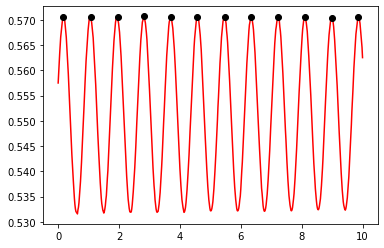

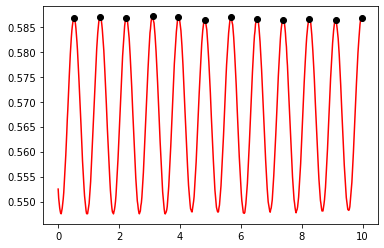

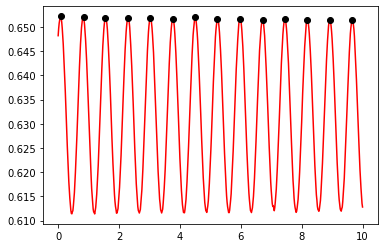

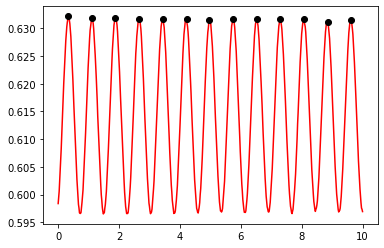

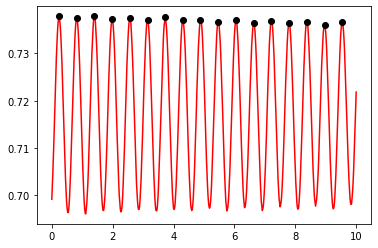

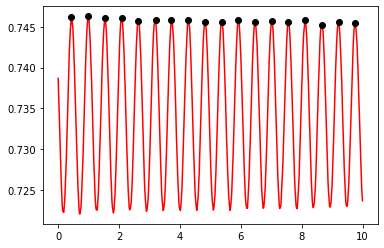

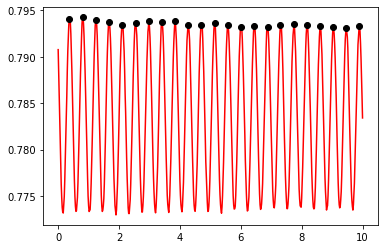

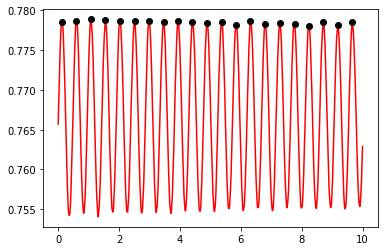

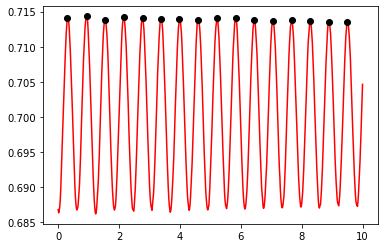

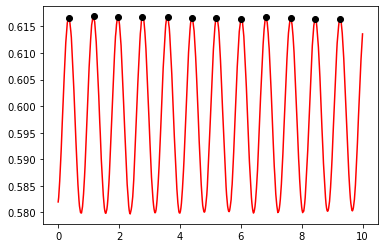

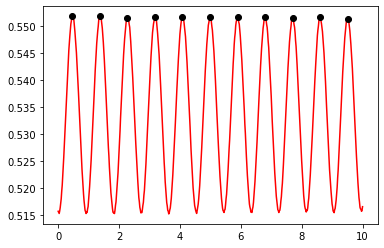

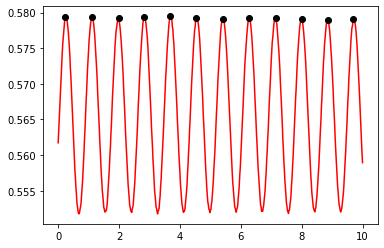

False


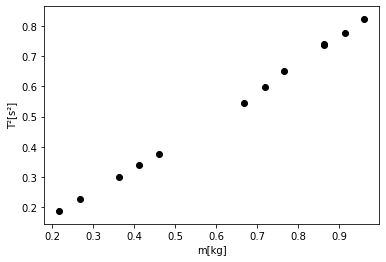

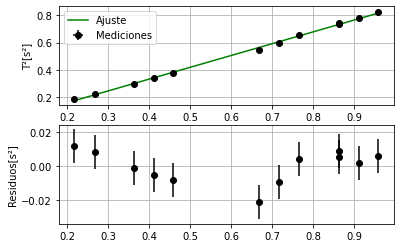

In [11]:
def temp_calc(filename):
    ts,pos = leermd(filename)
    idx_max = pk(pos,height=np.mean(pos),distance=len(pos)/30)[0]
    temps = []
    for i in range(len(idx_max)):
        temps.append(ts[idx_max[i]])
    plt.plot(ts,pos,'r')
    plt.plot(temps,pos[idx_max],'ko')
    prd = np.mean(np.diff(temps))
    return prd

temps_dyn = np.zeros(len(m_list))
for i in range(len(temps_dyn)):
    temps_dyn[i] = temp_calc(str(i+1)+'-D.txt')**2
    plt.show()

points_dyn,adj_dyn,things_dyn,cambio_dyn = ejes_lineal(m_list,temps_dyn,err_m,err_t)
print(cambio_dyn)
A_dyn = things_dyn[0][0]
B_dyn = things_dyn[0][1]
err_A_dyn = things_dyn[1][0]

plt.errorbar(points_dyn[0][0],points_dyn[0][1],xerr=points_dyn[1][0],yerr=points_dyn[1][1],fmt='ko',ecolor='k')
plt.xlabel('m[kg]')
plt.ylabel('T²[s²]')
plt.show()

ax1 = plt.subplot(2,1,1)
plt.errorbar(points_dyn[0][0],points_dyn[0][1],xerr=points_dyn[1][0],yerr=points_dyn[1][1],fmt='ko',ecolor='k',label='Mediciones')
plt.plot(adj_dyn[0],adj_dyn[1],'g',label='Ajuste')
plt.xlabel('m[kg]')
plt.ylabel('T²[s²]')
plt.legend()
plt.grid()

adj_rest_dyn = lineal(points_dyn[0][0],A_dyn,B_dyn)

ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.errorbar(points_dyn[0][0],points_dyn[0][1]-adj_rest_dyn,xerr=points_dyn[1][0],yerr=points_dyn[1][1],fmt='ko',ecolor='k')
plt.ylabel('Residuos[s²]')
plt.grid()

In [12]:
k0_dyn = 4*np.pi**2/-A_dyn
dk_dyn = abs(-4*np.pi**2/A_dyn**2 * err_A_dyn**2)
print('k = (' + str(round(k0_dyn,-int(floor(np.log10(abs(dk_dyn)))))) + ' ± ' + str(round(dk_dyn,-int(floor(np.log10(abs(dk_dyn)))))) + ') N/m')

k = (45.7888786 ± 9e-07) N/m


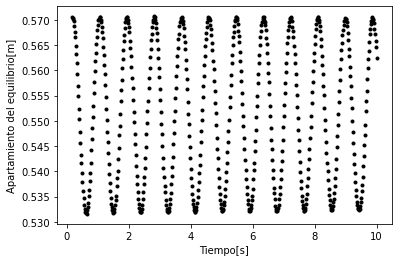

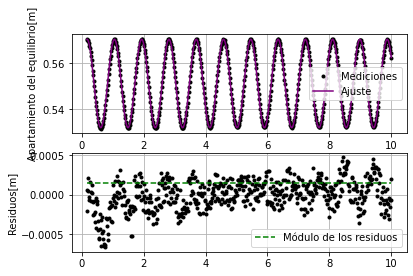

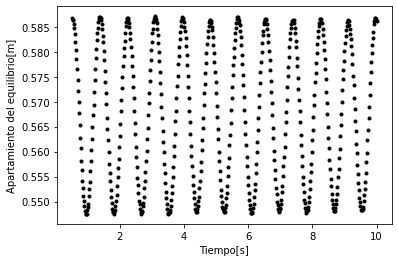

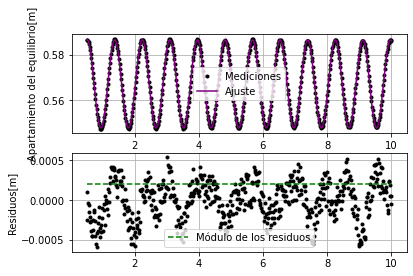

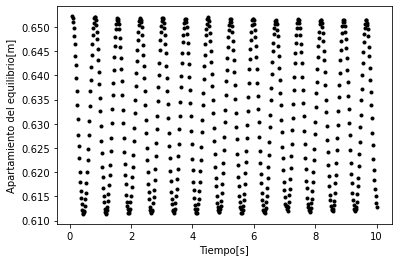

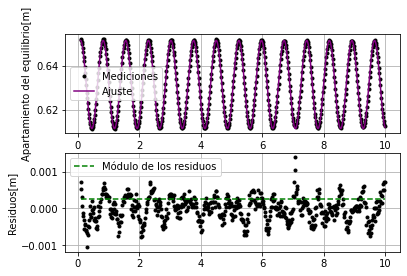

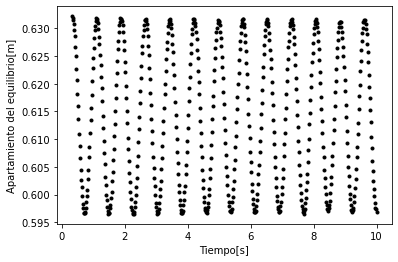

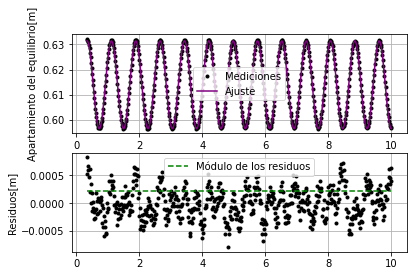

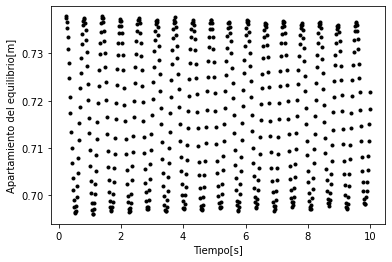

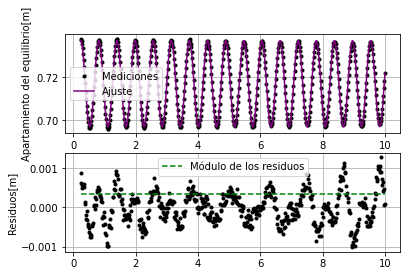

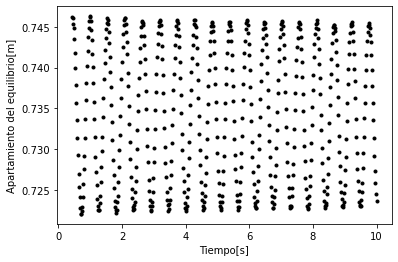

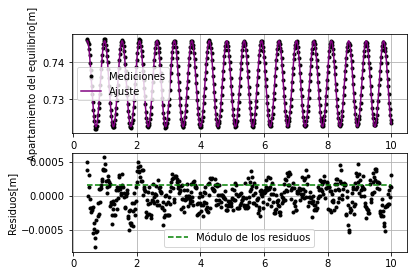

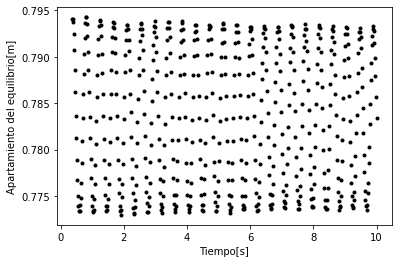

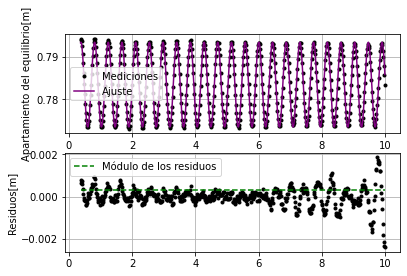

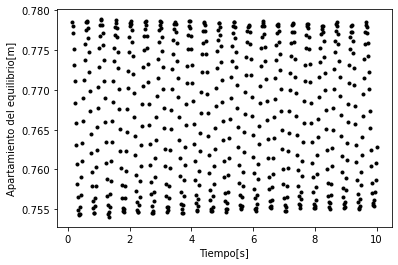

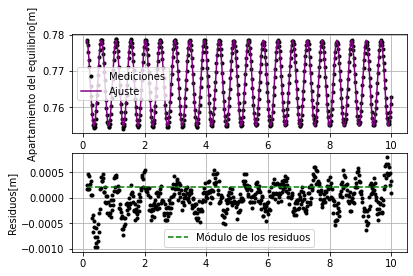

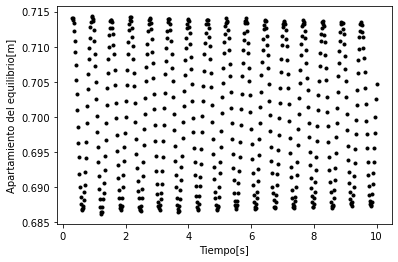

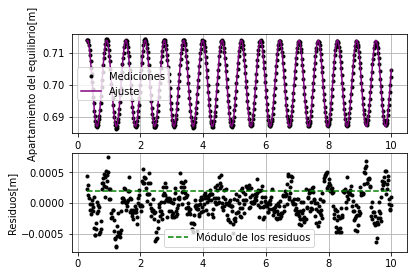

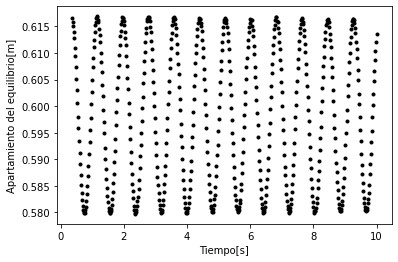

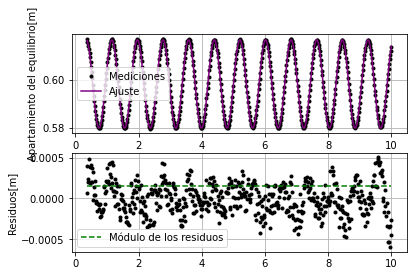

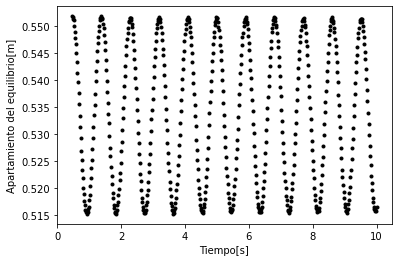

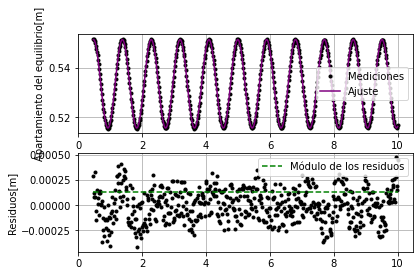

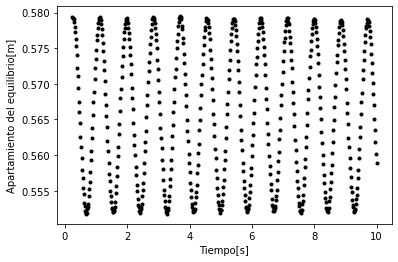

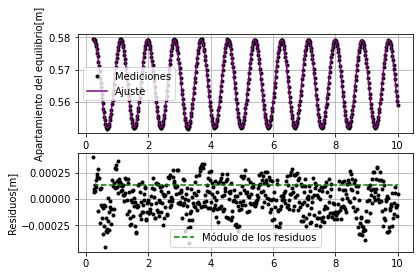

In [13]:
def adj_sin(x,A,w,phi,B): return A*np.sin(w*x+phi)+B

def acorte_max_in(t,p):
    max_1 = pk(p,height=np.mean(p),distance=len(p)/30)[0][0]
    ts = t[max_1:len(t)]
    pos = p[max_1:len(t)]
    return ts,pos

def dinamic_adj(n,time_error,pos_error):
    ts,pos=leermd(str(n)+'-D.txt')
    x,y=acorte_max_in(ts,pos)
    xpc = [max(pos)-min(pos),np.sqrt(k0_dyn/m_list[n-1]),0,1]
    err_x = time_error
    err_y = pos_error
    err_y_array = np.ones_like(y)
    for i in range(len(y)):
        err_y_array[i] = err_y
        popt,cov = cf(adj_sin,x,y,p0=xpc)
    A,w,phi,B = popt
    err_A = cov[0,0]
    err_w = cov[1,1]
    err_phi = cov[2,2]
    err_B = cov[3,3]
    x_adj = np.linspace(min(x),max(x),1000)
    y_adj = adj_sin(x_adj,A,w,phi,B)
    return [[x,y],[err_x,err_y]],[x_adj,y_adj],[[A,w,phi,B],[err_A,err_w,err_phi,err_B]]

w_list = []
for i in range(len(m_list)):
    pts_pos,adj_pos,things_pos = dinamic_adj(i+1,err_t,err_m,)
#    plt.errorbar(pts_pos[0][0],pts_pos[0][1],xerr=pts_pos[1][0],yerr=pts_pos[1][1],fmt='ko',ecolor='k')
    plt.plot(pts_pos[0][0],pts_pos[0][1],'k.')
    plt.xlabel('Tiempo[s]')
    plt.ylabel('Apartamiento del equilibrio[m]')
    plt.show()
    A,w,phi,B = things_pos[0]
    w_list.append(w)
    
    ax1 = plt.subplot(2,1,1)
    plt.plot(pts_pos[0][0],pts_pos[0][1],'k.',label='Mediciones')
    plt.plot(adj_pos[0],adj_pos[1],'purple',label='Ajuste')
    plt.legend()
    plt.xlabel('Tiempo[s]')
    plt.ylabel('Apartamiento del equilibrio[m]')
    plt.grid()
    
    ax2 = plt.subplot(2,1,2, sharex=ax1)
    plt.plot(pts_pos[0][0],pts_pos[0][1]-adj_sin(pts_pos[0][0],A,w,phi,B),'k.')
    adj_mean = np.ones_like(pts_pos[0][1])
    for i in range(len(adj_mean)):
        adj_mean[i] = np.mean(abs(pts_pos[0][1]-adj_sin(pts_pos[0][0],A,w,phi,B)))
    plt.plot(pts_pos[0][0],adj_mean,'g--',label='Módulo de los residuos')
    plt.ylabel('Residuos[m]')
    plt.grid()
    plt.legend()
    plt.show()

In [14]:
print(w_list)
k0_list = []
for i in range(len(w_list)):
    k0_list.append((w_list[i])**2*m_list[i])
print(k0_list)
print(np.mean(k0_list))
print(min(k0_list),max(k0_list))
print(k0_dyn)
print(k0_st)

[7.129137360757086, 7.315991969631839, 8.527731923881438, 8.127530487917715, 10.806224112108875, 11.467043406319293, 14.503957421367268, 13.167241528506278, 10.253650491522613, 7.752728883653716, 6.952405568409126, 7.3075382523387225]
[46.380496527515554, 46.18509871402129, 48.577710237294205, 47.40959135736767, 48.14693534440804, 47.68465215670144, 45.73477591695962, 46.327347492135715, 48.26929261293563, 45.94753902553764, 46.37142544867071, 46.027695389778785]
46.92188001861052
45.73477591695962 48.577710237294205
45.78887862267168
29.242307699570638
